# Seasonal Effects

The purpose of this notebook is to examine what effect, if any, that historical seasonal match data has on predicting the outcomes of future matches. In particular, an aggregation of pre-season match data might be useful for providing prior estimates of quantities of interest.

## Load the data

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "python"))

In [2]:
import match_tools

In [3]:
from datetime import datetime as parse_datetime

import numpy as np
import pandas as pd

### Load match results

In [4]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [5]:
date_fn = lambda s: parse_datetime.strptime(s, match_tools.DATETIME_FORMAT)
df_matches['timestamp'] = df_matches.datetime.apply(date_fn)

In [6]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type,timestamp
0,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,4,3,4,89,0,False,False,True,defeated,1990-03-31 14:10:00
1,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,7,10,6,192,4,True,False,False,lost-to,1990-03-31 14:10:00
2,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,3,6,5,104,4,True,False,False,lost-to,1990-03-31 14:10:00
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,3,2,4,60,0,False,False,True,defeated,1990-03-31 14:10:00
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,3,3,2,74,0,False,False,True,defeated,1990-03-31 19:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,2022,R18,Sat 16-Jul-2022 5:30 PM,Perth Stadium,Fremantle,True,3,3,3,2,...,4,5,4,82,4,True,False,False,lost-to,2022-07-16 17:30:00
6166,2022,R18,Sat 16-Jul-2022 7:25 PM,M.C.G.,Carlton,True,4,1,1,0,...,2,2,5,85,4,True,False,False,lost-to,2022-07-16 19:25:00
6167,2022,R18,Sun 17-Jul-2022 1:10 PM,M.C.G.,Hawthorn,True,2,3,7,0,...,2,3,0,77,0,False,False,True,defeated,2022-07-17 13:10:00
6168,2022,R18,Sun 17-Jul-2022 2:50 PM,Traeger Park,Melbourne,True,0,4,5,3,...,3,3,3,69,0,False,False,True,defeated,2022-07-17 14:50:00


### Load end-of-season statistics

In [7]:
df_seasonal = pd.read_csv(os.path.join("..", "data", "end_season_features.csv"))

In [8]:
df_seasonal

,season,team,teams,games,wins,draws,losses,wins_ratio,points_for,points_against,...,behinds_against,accuracy_against,goals_ratio,behinds_ratio,rank,rank_score,wins_prestige,adj_wins_prestige,points_prestige,adj_points_prestige
0,1990,Brisbane Bears,14,22,4,0,18,0.181818,1733,2426,...,338,0.507289,0.415126,0.426146,14,0.000000,0.003774,0.046936,0.049030,0.401289
1,1990,Carlton,14,22,11,0,11,0.500000,2277,2187,...,315,0.497608,0.517774,0.458763,8,0.461538,0.055508,0.433112,0.073333,0.507091
2,1990,Collingwood,14,26,19,1,6,0.750000,2798,2077,...,313,0.484349,0.578797,0.544396,1,1.000000,0.232418,0.797419,0.096696,0.581871
3,1990,Essendon,14,25,18,0,7,0.720000,2742,2079,...,297,0.500000,0.571429,0.552036,2,0.923077,0.172837,0.730920,0.096170,0.580403
4,1990,Fitzroy,14,22,7,0,15,0.318182,1874,2389,...,319,0.519578,0.433498,0.476190,12,0.153846,0.019412,0.204675,0.057674,0.443097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,18,17,9,0,8,0.529412,1631,1418,...,200,0.503722,0.540724,0.496222,8,0.588235,0.035989,0.388251,0.058767,0.514896
541,2022,St Kilda,18,17,9,0,8,0.529412,1333,1311,...,195,0.488189,0.509235,0.472973,10,0.470588,0.052259,0.483842,0.057077,0.507158
542,2022,Sydney,18,17,11,0,6,0.647059,1546,1280,...,176,0.511111,0.549020,0.534392,6,0.705882,0.103283,0.661940,0.065234,0.542620
543,2022,West Coast,18,17,2,0,15,0.117647,1084,1888,...,202,0.581781,0.361364,0.391566,17,0.058824,0.008256,0.123970,0.032211,0.361357


In [9]:
all_seasons = sorted(set(df_seasonal.season))

# Exclude the last season, as it is currently incomplete
removed_season = all_seasons[-1]
all_seasons = all_seasons[:-1]
df_seasonal = df_seasonal.loc[df_seasonal.season < removed_season].copy()

## Seasonal prediction

We begin by looking at how well statistics from the previous season can be used to predict the current season.
We 
[recall](3_feature_extraction.ipynb#Numbers-of-wins,-draws-and-losses
"Feature Extraction: Numbers of wins, draws and losses") 
that the *wins ratio* measures the proportion of all games within a given season won by a team (with allowances for draws). This gives an objective measure of a team's strength or weakness for that season. However, the measure is coarse, since a loss by 1 point is no different to a loss by 100 points. A more refined measure would therefore take account of the points margin of wins and losses (with zero margin for a draw).
We
[recall](3_feature_extraction.ipynb#Points-for-and-against
"Feature Extraction: Points for and against") that such a measure is provided by the *points ratio*, although this quantity has a more subjective interpretation than the wins ratio.

Another features of interest is the *rank score*, which is derived from the
[league rankings](3_feature_extraction.ipynb#League-ranking
"Feature Extraction: League ranking") but normalised to be independent of the number of teams.
Finally, the last feature of interest is the *prestige score*, which measures
the fictional flow of 
[prestige](3_feature_extraction.ipynb#Prestige-scores
"Feature Extraction: Prestige scores") from losing teams to winning teams. 
Note that we utilise adjusted versions of both these measures,
that are normalised to be comparable between different seasons with different numbers of teams.

### Intra-seasonal relationships

Our first test of the predictive effect of various features is to examine their relationships within the same
season. Note that this is not really a fair test, since the outcome of each match contributes to both
the wins ratio and the points ratio, and the wins (and draws) determine the match points (and score points for ties) from which the league rankings are derived. Our test, therefore is merely meant to be indicative in the sense that the various aggregated features should be strongly correlated with each other.

In [10]:
import matplotlib.pyplot as plt

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
def intra_seasonal_plot(x_field, y_field):
    X = df_seasonal[x_field].values
    Y = df_seasonal[y_field].values
    plt.plot(X, Y, 'o')

    X = X.reshape((-1, 1))    
    model = LinearRegression(fit_intercept=False).fit(X, Y)
    beta0 = model.coef_[0]
    x = np.linspace(np.min(X), np.max(X), 100)
    y = beta0 * x
    plt.plot(x, y, 'g')

    model = LinearRegression(fit_intercept=True).fit(X, Y)
    R2 = model.score(X, Y)
    alpha = model.intercept_
    beta = model.coef_[0]
    y = alpha + beta * x
    plt.plot(x, y, 'r')

    mu = alpha / (1 - beta)
    plt.plot(x, [mu] * len(x), 'b')

    plt.title(f"Intra-seasonal predictability: {x_field} -> {y_field}")
    plt.xlabel(f"Predictor: {x_field}")
    plt.ylabel(f"Predicted: {y_field}")
    plt.legend(['data','no intercept','with intercept','mean'])
    plt.show()
    return R2, mu, alpha, beta, beta0

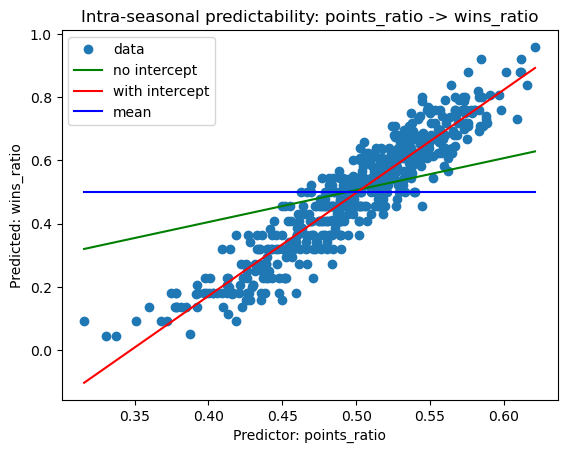

R^2=0.8754510845065487


In [13]:
res = intra_seasonal_plot('points_ratio', 'wins_ratio')
print(f"R^2={res[0]}")

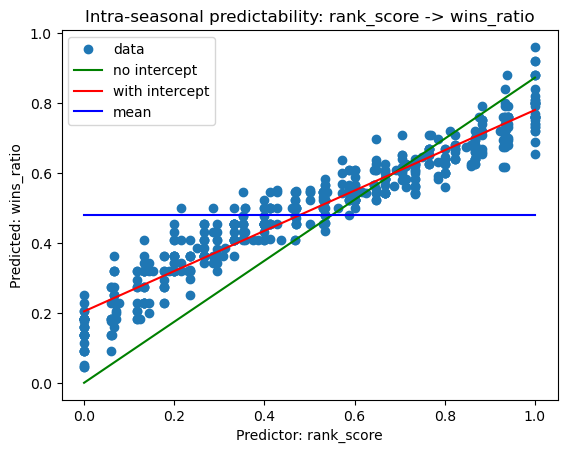

R^2=0.9187584427643045


In [14]:
res = intra_seasonal_plot('rank_score', 'wins_ratio')
print(f"R^2={res[0]}")

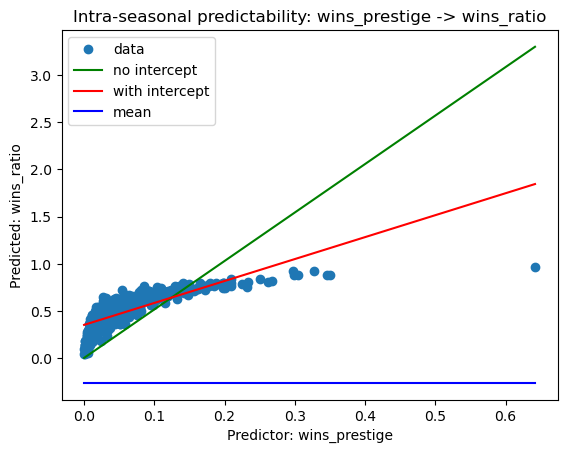

R^2=0.6188299362245212


In [15]:
res = intra_seasonal_plot('wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}")

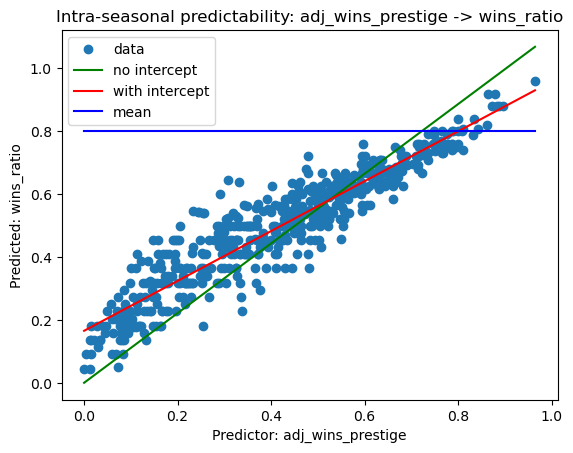

R^2=0.8670120121643263


In [16]:
res = intra_seasonal_plot('adj_wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}")

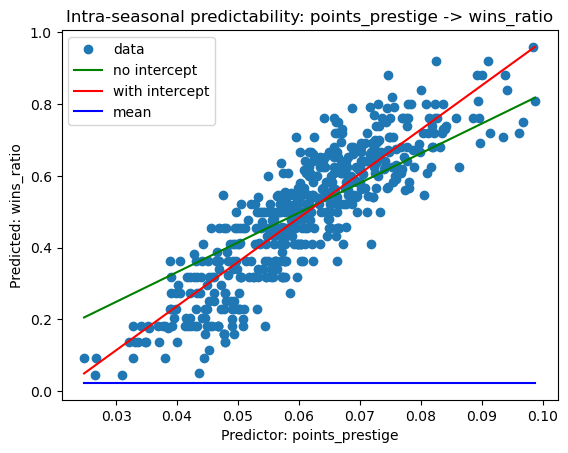

R^2=0.7605995123662842


In [17]:
res = intra_seasonal_plot('points_prestige', 'wins_ratio')
print(f"R^2={res[0]}")

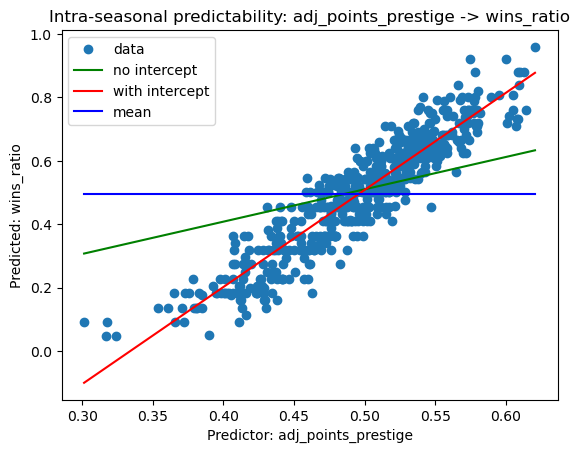

R^2=0.8575924705117781


In [18]:
res = intra_seasonal_plot('adj_points_prestige', 'wins_ratio')
print(f"R^2={res[0]}")

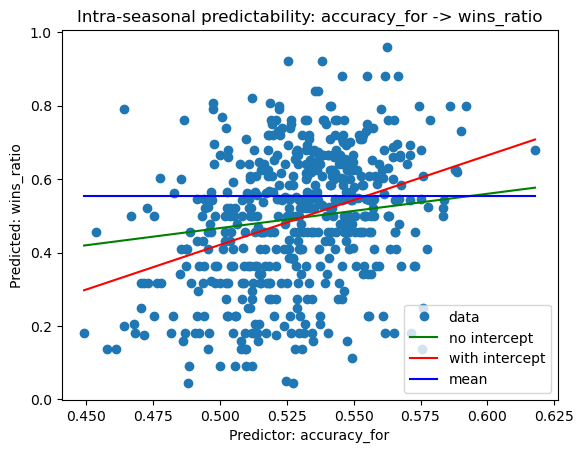

R^2=0.11880489440838471


In [19]:
res = intra_seasonal_plot('accuracy_for', 'wins_ratio')
print(f"R^2={res[0]}")

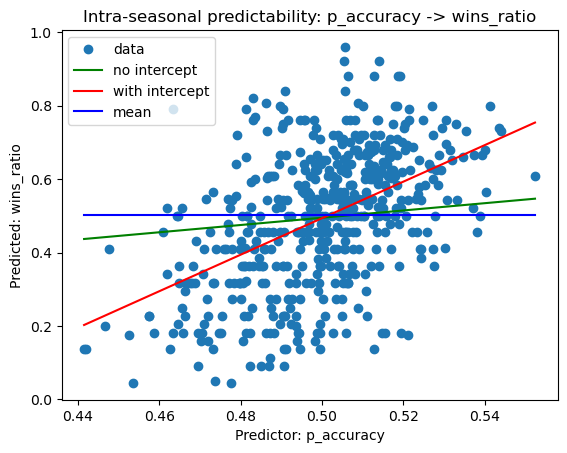

R^2=0.23682503922343634


In [20]:
acc_for = df_seasonal.accuracy_for.values
acc_against = df_seasonal.accuracy_against.values
p_acc = acc_for / (acc_for + acc_against)
df_seasonal['p_accuracy'] = p_acc

res = intra_seasonal_plot('p_accuracy', 'wins_ratio')
print(f"R^2={res[0]}")

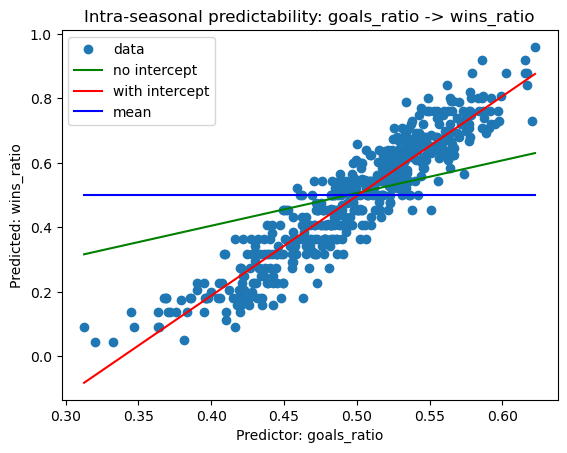

R^2=0.8677086030004084


In [21]:
res = intra_seasonal_plot('goals_ratio', 'wins_ratio')
print(f"R^2={res[0]}")

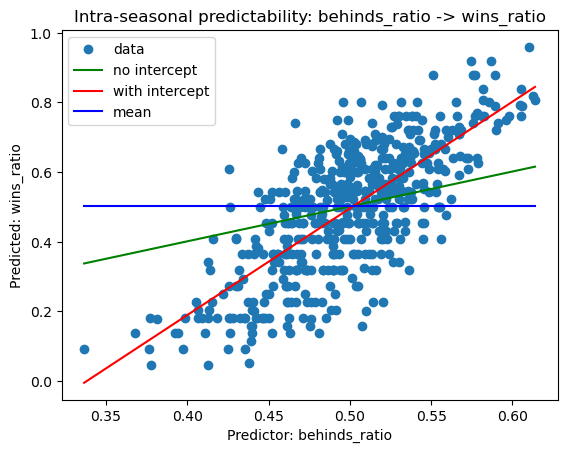

R^2=0.5551006788790225


In [22]:
res = intra_seasonal_plot('behinds_ratio', 'wins_ratio')
print(f"R^2={res[0]}")

We conclude that the seasonal features are, as expected, mostly strongly correlated with each other *within the same season*. The exception appears to be the measure of goal scoring accuracy, i.e. the proportion of scoring shots that are goals rather than behinds. 
One might expect that a high goal-scoring accuracy would be indicative of a strong team, which would in turn lead one to expect a higher proportion of wins for that team.
For whatever reason, this effect seems to be very weak.

### Inter-seasonal relationships

Our next test, a fairer one, is to examine the relationships between the features computed both at the end of one season and at the end of the next season. Such relationships directly indicate how strongly the results of  one season may be used to predict the next. The 'business as usual' or null hypothesis is that one season is much like the next, subject to chance fluctuations. Mitigating against this hypothesis is the fact that,
as noted in the 
[introduction](1_introduction.ipynb#Temporal-heterogeneity "Introduction: Temporal heterogeneity"), 
teams change in player composition from season to season, and thus change in attacking and defending capabilities over time,
so that in some seasons a team might be systematically stronger or weaker than in other seasons.

This latter issue also suggests that there might be a *reversion-to-the-mean* effect, such that a good or bad season for any given team might likely be followed by a more average season. To test this idea,
we fit the unconstrained, linear relationship $y=\alpha+\beta x$ between the variate $x$ of one season and the variate $y$ of the next season. If $0<\beta<1$, then this is equivalent to the mean-reversion model
$y=\mu+\beta(x-\mu)$ for $\mu=\frac{\alpha}{1-\beta}$.

In [23]:
def inter_seasonal_features(prev_field, cur_field):
    prev_values = []
    cur_values = []
    it = iter(all_seasons)
    prev_season = next(it)
    prev_features = df_seasonal[df_seasonal.season == prev_season]
    for cur_season in it:
        cur_features = df_seasonal[df_seasonal.season == cur_season]
        for idx, team_features in cur_features.iterrows():
            team = team_features['team']
            ind = prev_features.team == team
            if not any(ind):
                # Team has merged or changed name
                continue
            cur_values.append(team_features[cur_field])
            prev_value = prev_features.loc[ind, prev_field].values[0]
            prev_values.append(prev_value)
        prev_features = cur_features
    return prev_values, cur_values

In [24]:
def inter_seasonal_plot(prev_field, cur_field):
    prev_values, cur_values = inter_seasonal_features(prev_field, cur_field)
    plt.plot(prev_values, cur_values, 'o')

    X = np.array(prev_values).reshape((-1, 1))
    Y = np.array(cur_values)
    
    model = LinearRegression(fit_intercept=False).fit(X, Y)
    beta0 = model.coef_[0]
    x = np.linspace(min(prev_values), max(prev_values), 100)
    y = beta0 * x
    plt.plot(x, y, 'g')

    model = LinearRegression(fit_intercept=True).fit(X, Y)
    R2 = model.score(X, Y)
    alpha = model.intercept_
    beta = model.coef_[0]
    y = alpha + beta * x
    plt.plot(x, y, 'r')

    mu = alpha / (1 - beta)
    plt.plot(x, [mu] * len(x), 'b')

    plt.title(f"Seasonal predictability of {prev_field} -> {cur_field}")
    plt.xlabel(f"Previous season: {prev_field}")
    plt.ylabel(f"Current season: {cur_field}")
    plt.legend(['data','no intercept','with intercept','mean'])
    plt.show()
    return R2, mu, alpha, beta, beta0

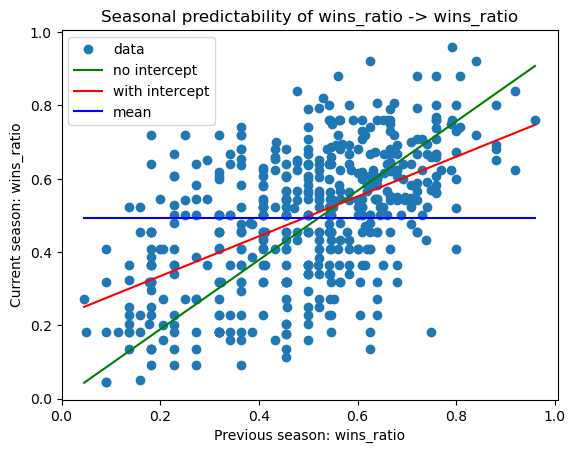

Linear fit without intercept: beta=0.9454418855237011
Linear fit with intercept: alpha=0.22546871743786245, beta=0.5431984407838794, R^2=0.2950474161276585
Mean-reversion fit: mu=0.49358132188684, beta=0.5431984407838794


In [25]:
R2, mu, alpha, beta, beta0 = inter_seasonal_plot('wins_ratio', 'wins_ratio')
print(f"Linear fit without intercept: beta={beta0}")
print(f"Linear fit with intercept: alpha={alpha}, beta={beta}, R^2={R2}")
print(f"Mean-reversion fit: mu={mu}, beta={beta}")

Since $0<\beta\approx 0.545<1$, we conclude that the wins ratio $y$ of the current season is typically closer to the mean $\mu\approx0.49$ than the wins ratio $x$ of the previous season. In other words, there does seem to be a mean-reversion effect.

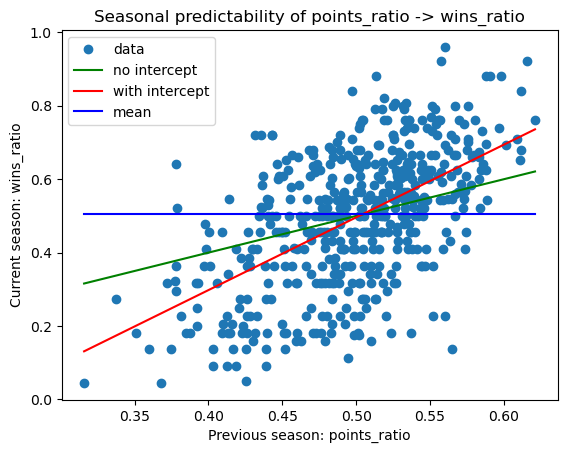

R^2=0.32036564187204863


In [26]:
res = inter_seasonal_plot('points_ratio', 'wins_ratio')
print(f"R^2={res[0]}")

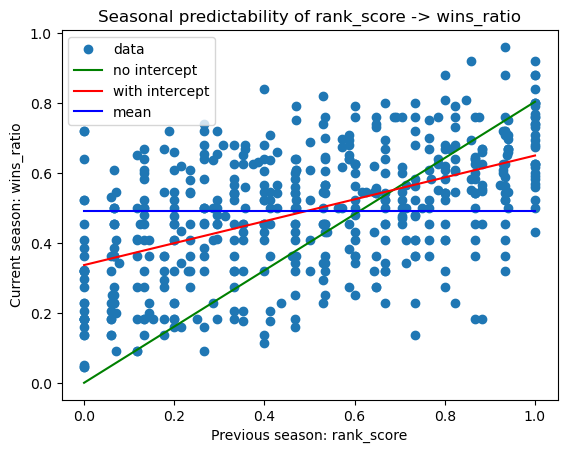

R^2=0.27141086295437467


In [27]:
res = inter_seasonal_plot('rank_score', 'wins_ratio')
print(f"R^2={res[0]}")

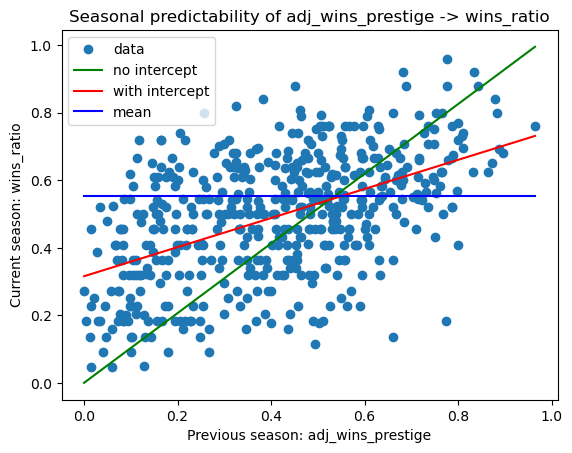

R^2=0.25749718743412764


In [28]:
res = inter_seasonal_plot('adj_wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}")

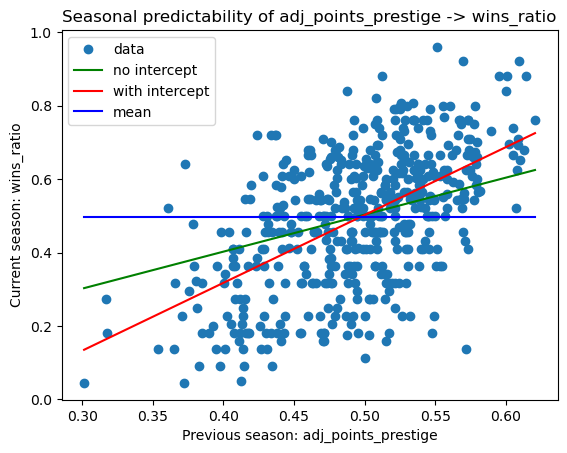

R^2=0.31154806943813385


In [29]:
res = inter_seasonal_plot('adj_points_prestige', 'wins_ratio')
print(f"R^2={res[0]}")

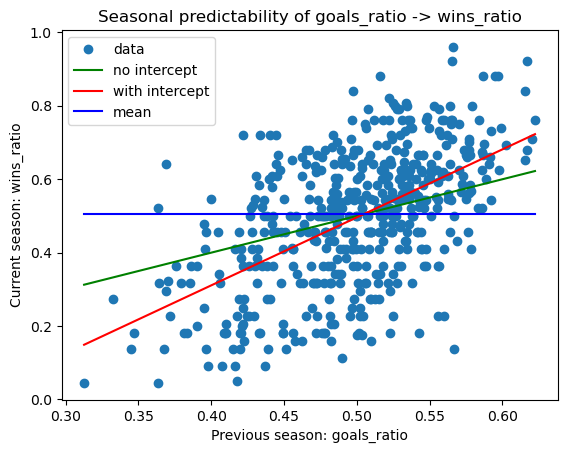

R^2=0.3094494536985464


In [30]:
res = inter_seasonal_plot('goals_ratio', 'wins_ratio')
print(f"R^2={res[0]}")

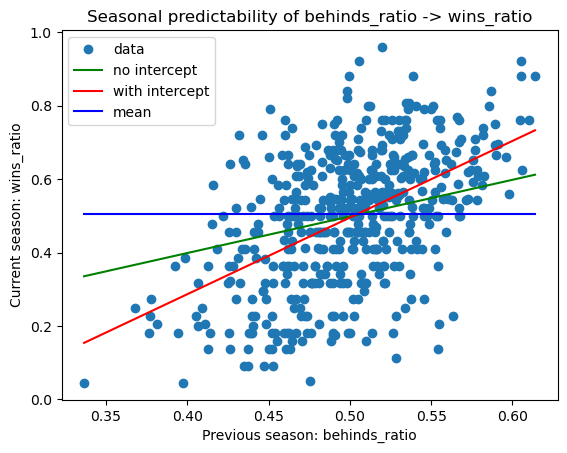

R^2=0.26027420095517484


In [31]:
res = inter_seasonal_plot('behinds_ratio', 'wins_ratio')
print(f"R^2={res[0]}")

As expected, there is a larger amount of variability for inter-seasonal prediction compared to intra-seasonal prediction. However, overall there do seem to be weakly positive linear correlations, with the possible exception of the rank score, which appears visually to be uncorrelated with the next season's wins ratio.

Note that the lack of predictability from one season to the next can partly be attributed to the league player draft that happens at the end of each season, which is explicitly designed to allow weaker teams to draft stronger players, in order to help even out the competition for the next season.
In other words, we might expect the weakest teams in any one season to improve in the next season, at the expense of the 'average' teams. However, the strongest teams would likely try to retain their best players, and might not be as affected by the draft, although they perhaps could afford to release some older players and take on some younger players, which might affect performance.

## Multi-seasonal prediction

In the [previous](#Seasonal-prediction "Section: Seasonal prediction") section,
we computed summary statistics aggregated over all matches per team within each season. With the aid of these per-season statistics, we also briefly examined the effect of predicting one season's statistics from the
previous season's statistics. Overall, with the exception of the rank score, there appeared to be a weak but definite predictive effect.

This raises the question of whether incorporating further past seasons will boost the predictive effect.
On the one hand, using multiple seasons might provide some measure of variability, and thus aid in smoothing
over exceptionally good or bad seasons. On the other hand, team changes over time possibly mean that a season long past may be a poor predictor of the future.

The proportions of wins, draws and losses for a given team for a particular season measure that team's success against all other teams,
and provide a predictor of the next season. That is, the proportions may be interpreted as probabilities.
Hence, we shall take a 
[weighted average](A_additive_weights.ipynb "Appendix A: Additively Weighted Models")
of the past seasons' proportions as a predictor of the proportions for the
following season.

Equivalently, we intend to fit a linear auto-regressive model to seasonal, per-team time-series data.
In order to get a feel for how difficult this task is in practice, we plot the wins ratio time-series below.

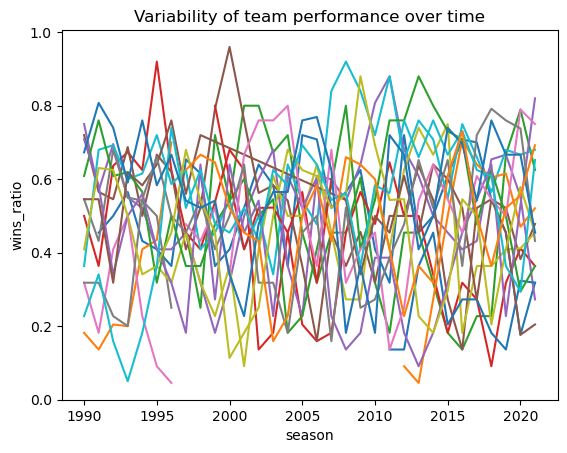

In [32]:
all_teams = sorted(set(df_seasonal.team))
for team in all_teams:
    team_data = df_seasonal.loc[df_seasonal.team == team, ['season', 'wins_ratio']]
    plt.plot(team_data.season, team_data.wins_ratio.values)
plt.title("Variability of team performance over time")
plt.xlabel('season')
plt.ylabel('wins_ratio')
plt.show()

### Extract seasonal proportions

We start our modelling by estimating the overall proportion of drawn matches. Other than draws, we expect *a priori* that the proportions of wins and losses should be equal.

In [33]:
prob_draw = sum(df_seasonal.draws) / sum(df_seasonal.games)
prob_win = prob_loss = (1 - prob_draw) / 2
prior_probs = np.array([prob_win, prob_draw, prob_loss])
print(prior_probs)

[0.49559581 0.00880838 0.49559581]


Since draws are rare events, the accurate prediction of drawn matches is problematic. To help ease this problem, we smooth the per-season statistics with the global prior before computing the proportions.

In [34]:
stats = ['wins', 'draws', 'losses']
df_experim = df_seasonal[['season', 'team', 'games'] + stats].copy()
for field in stats:
    df_experim[field] = df_experim[field].astype(float)

df_experim[stats] = df_experim[stats].values + prior_probs
for field in stats:
    df_experim[field] = df_experim[field] / (df_experim.games + 1)

In [35]:
df_experim

,season,team,games,wins,draws,losses
0,1990,Brisbane Bears,22,0.195461,0.000383,0.804156
1,1990,Carlton,22,0.499809,0.000383,0.499809
2,1990,Collingwood,26,0.722059,0.037363,0.240578
3,1990,Essendon,25,0.711369,0.000339,0.288292
4,1990,Fitzroy,22,0.325895,0.000383,0.673722
...,...,...,...,...,...,...
522,2021,Richmond,22,0.412852,0.043861,0.543287
523,2021,St Kilda,22,0.456330,0.000383,0.543287
524,2021,Sydney,23,0.645650,0.000367,0.353983
525,2021,West Coast,22,0.456330,0.000383,0.543287


We now collect the per-season proportions across all seasons for each team.

In [36]:
all_teams = sorted(set(df_experim.team))

team_data = {}
for team in all_teams:
    team_data[team] = df_experim.loc[df_experim.team == team, stats].values.copy()

### Temporal averaging

In order to measure the temporal effect of seasonal data, for each team we extract a collection of contexts and
targets. Each target represents the per-season statistics of a given team for a given season,
and the corresponding context represents the previous $K$ seasons of statistics.
In effect, for each team we take a sliding window of $K+1$ seasons as the training data.

In [37]:
from numpy.lib.stride_tricks import sliding_window_view

In [38]:
def get_target_contexts(team_data, num_context):
    values = next(iter(team_data.values()))
    num_classes = values.shape[1]  # C
    window_shape = (num_context + 1, num_classes)
    contexts = []  # N x K x C
    targets = []   # N x C
    for team, values in team_data.items():
        if values.shape[0] < window_shape[0]:
            # Too few seasons - ignore team
            continue
        sequences = sliding_window_view(values, window_shape)
        sequences = sequences[:, 0, :, :]
        contexts.append(sequences[:, :-1, :])
        targets.append(sequences[:, -1, :])
    contexts = np.vstack(contexts)
    targets = np.vstack(targets)
    return targets, contexts

Before we start the modelling, we should consider some aspects of both the data and the model.
Firstly, we only have about 30 years of data, due to our pre-determined date cut-off of 1990.
Hence, choosing $K\approx 30$ will run into problems with scarcity of data, thus affecting model fitting.
This problem should be reduced as $K$ becomes smaller, with $K\approx 15$ resulting in a sliding window of about 15 seasons to model about 15 future seasons. Beyond $K\approx 15$ might be problematic (i.e. producing untrustworthy results).

Secondly, we expect that as the number $K$ of model parameters increases, the model becomes more exprerssive and should fit the training data 
better and better (except near $K\approx 30$), thus typically leading to over-fitting. Furthermore, due to
the iterative nature of the parameter estimation, in the absence of parameter regularisation and model validation, we also expect over-fitting of the training data for any given $K$. Consequently, we should treat the interpretation of the resulting weights with some caution.

For convenience, we shall arbitrary take $K=15$ for the next analysis.

In [39]:
num_context = 15  # K
targets, contexts = get_target_contexts(team_data, num_context)
print(targets.shape)
print(contexts.shape)

(236, 3)
(236, 15, 3)


For the [additive model](A_additive_weights.ipynb#Additive-model
"Appendix A: Additive model"),
we give each season in the context a non-negative weight, say $w_k$, such that these weights sum to unity.
The overall prediction is then the weighted sum of the context.
We use
[quasi-supervised](A_additive_weights.ipynb#Quasi-Supervised-Training
"Appendix A: Quasi-Supervised Training")
training to choose these weights to minimise the cross-entropy of the context given the target.
Note that the contexts specify $P(c\mid\mathbf{x}_k^{(d)},\Theta)$, and the targets specify
$P(c\mid\vec{\mathbf{x}}^{(d)},\Gamma)$.

In [40]:
def score_weights(target_probs, context_probs, weights=None):
    num_context = context_probs.shape[1]  # K
    if weights is None:
        weights = np.ones(num_context) / num_context
    posterior_probs = [None] * num_context  # K x N x C
    # Compute P(k,c|x)
    for k in range(num_context):
        posterior_probs[k] = weights[k] * context_probs[:,k,:]
    # Compute P(c|x)
    predicted_probs = sum(posterior_probs)  # N x C
    # Compute L(Theta)
    L = np.mean(np.sum(target_probs * np.log(predicted_probs), axis=1))
    # Compute P(k|c,x)
    for k in range(num_context):
        posterior_probs[k] /= predicted_probs
    # Update P(k)
    new_weights = np.zeros(num_context)
    for k in range(num_context):
        new_weights[k] = np.mean(np.sum(target_probs * posterior_probs[k], axis=1))
    return L, new_weights

In [41]:
def iterate_estimates(target_probs, context_probs, tol=1e-8):
    scores = []
    L0, weights = score_weights(target_probs, context_probs)
    scores.append(L0)
    L1, weights = score_weights(target_probs, context_probs, weights)
    scores.append(L1)
    while L1 - L0 >= tol:
        L0 = L1
        L1, weights = score_weights(target_probs, context_probs, weights)
        scores.append(L1)
    return weights, scores

In [42]:
weights, scores = iterate_estimates(targets, contexts)
L1 = scores[-1]
L0 = scores[-2]
print(f"score={L1}, convergence={L1-L0}, #iterations={len(scores)}")
print("model weights:\n", weights)

score=-0.7198193632100739, convergence=9.97581506290146e-09, #iterations=1124
model weights:
 [7.14284458e-02 1.30747200e-02 3.70199044e-07 5.64091987e-02
 8.74928663e-02 1.67925672e-02 1.06680993e-03 1.22984977e-04
 6.59964929e-02 9.76020986e-06 3.01933786e-02 4.32734912e-02
 8.17450454e-02 4.03312412e-04 5.31990556e-01]


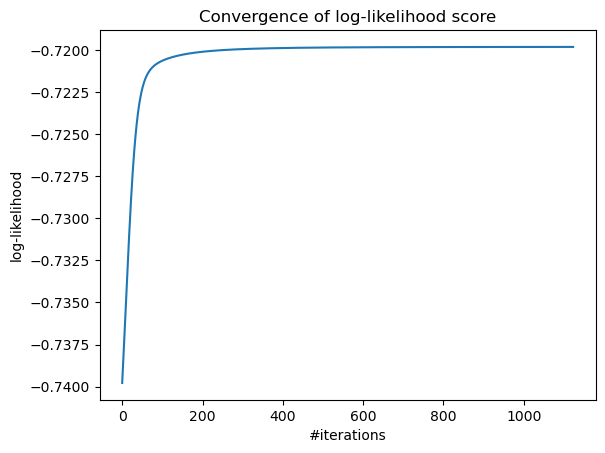

In [43]:
plt.plot(scores)
plt.title("Convergence of log-likelihood score")
plt.xlabel("#iterations")
plt.ylabel("log-likelihood")
plt.show()

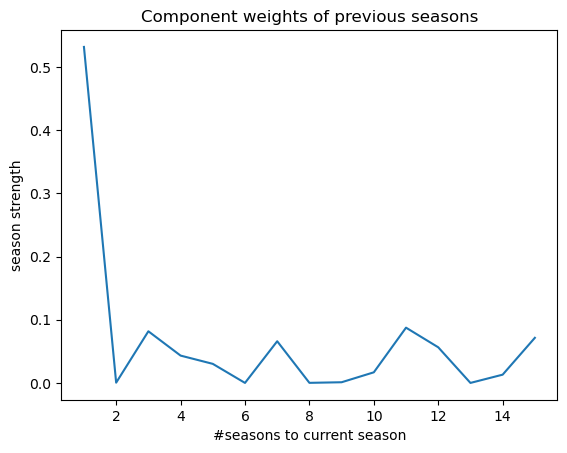

In [44]:
rweights = list(weights)
rweights.reverse()
steps = range(1, num_context + 1)

plt.plot(steps, rweights)
plt.title("Component weights of previous seasons")
plt.xlabel("#seasons to current season")
plt.ylabel("season strength")
plt.show()

We observe that the season immediately prior to a given season (say, $k=1$) is given the greatest weight (say $w_1$), with all other past seasons ($k>1$) given a low weight ($w_k$) of about the same magnitude, i.e. $\approx\frac{1}{K}$. 
In futher experiments (not shown here), this pattern persists irrespective of the number $K$ of
past seasons. We attach no significance to the variance in weights across the low-weighted seasons, since this oscillating variation also persists independently of $K$, except that the weights of past seasons may abitrarily be higher or lower as $K$ varies. We attribute this to over-fitting the data, as discussed above.

This pattern of weights also appears when optimisating models with other objective functions, e.g. linear regression using least square error (via stacking the $C$ classes of $N$ cases into $NC$ cases). Also note that, instead of a weighted additive model, one may use a weighted multiplicative model. Under the *logit* transform $\sigma^{-1}(p)=\ln\frac{p}{1-p}$ of the features, this may also be re-cast into a weighted additive model. Further experiments with this new model
also showed the same pattern of weights. In particular, use of `LassoCV`, i.e.
linear regression with an $L_1$ weight regulariser and using cross-validation, repeatedly gave zero or near-zero weights (for various values of $K$) for all except weight $w_1$, corresponding to $K=1$. The [next](#Predictive-accuracy "Section: Predictive accuracy") section explores some of these results for fitting linear regression models via `LassoCV`.

We conclude that, for the purposes of predicting the current season, only the previous season appears to hold sufficient information.

### Predictive accuracy

Despite the fact that the additive model gives most weight to $K=1$, there might still be some predictive advantage in having $K>1$.
Let us therefore look at the predictive accuracy of including further past seasons. 
However, this time we will model the wins ratio of the current season as a linear regression of past seasons, ussing `LassoCV` to include cross-validation and weight penalisation.

As discussed [earlier](#Temporal-averaging "Section: Temporal averaging"), 
we expect model over-fitting as $K$ increases.
In order to approximately measure the effect of over-fitting, for each value of $K$ we estimate the parameters from a random selection of 80% of the training data, and evalue the resulting model on the remaining 20%.

In [45]:
adj_wins = df_experim.wins + 0.5 * df_experim.draws
adj_losses = df_experim.losses + 0.5 * df_experim.draws
df_experim['wins_ratio'] = adj_wins / (adj_wins + adj_losses)

In [46]:
df_experim

,season,team,games,wins,draws,losses,wins_ratio
0,1990,Brisbane Bears,22,0.195461,0.000383,0.804156,0.195652
1,1990,Carlton,22,0.499809,0.000383,0.499809,0.500000
2,1990,Collingwood,26,0.722059,0.037363,0.240578,0.740741
3,1990,Essendon,25,0.711369,0.000339,0.288292,0.711538
4,1990,Fitzroy,22,0.325895,0.000383,0.673722,0.326087
...,...,...,...,...,...,...,...
522,2021,Richmond,22,0.412852,0.043861,0.543287,0.434783
523,2021,St Kilda,22,0.456330,0.000383,0.543287,0.456522
524,2021,Sydney,23,0.645650,0.000367,0.353983,0.645833
525,2021,West Coast,22,0.456330,0.000383,0.543287,0.456522


In [47]:
team_data = {}
for team in all_teams:
    team_data[team] = df_experim.loc[df_experim.team == team, 'wins_ratio'].values.copy()

In [48]:
def get_target_contexts(team_data, num_context):
    window_size = num_context + 1
    contexts = []  # N x K
    targets = []   # N
    for team, values in team_data.items():
        num_windows = len(values) - num_context
        if num_windows < 1:
            # Too few seasons - ignore team
            continue
        for i in range(num_windows):
            sequence = values[i:(i+window_size)]
            contexts.append(sequence[:-1])
            targets.append(sequence[-1])
    contexts = np.vstack(contexts)
    targets = np.array(targets)
    return targets, contexts

In [49]:
def validation_estimation_split(num_data, val_frac):
    val_idx = np.random.choice(num_data, int(num_data * val_frac), replace=False)
    est_mask = np.ones(num_data, dtype=bool)
    est_mask[val_idx] = False
    return val_idx, est_mask

In [50]:
from sklearn.linear_model import LassoCV

In [51]:
def run_one_experiment(team_data, val_frac, max_K):
    est_scores =[]
    val_scores = []
    weights = np.zeros((max_K, max_K))
    num_data = []
    for i in range(max_K):
        K = i + 1
        targets, contexts = get_target_contexts(team_data, K)
        val_idx, est_mask = validation_estimation_split(targets.shape[0], val_frac)
        val_targets = targets[val_idx]
        val_contexts = contexts[val_idx,:]
        est_targets = targets[est_mask]
        est_contexts = contexts[est_mask,:]
        num_data.append(len(est_targets))
        model = LassoCV(max_iter=50000).fit(est_contexts, est_targets)
        weights[i,0:K] = model.coef_.flatten()[::-1]
        est_scores.append(model.score(est_contexts, est_targets))
        val_scores.append(model.score(val_contexts, val_targets))
    return weights, np.array(est_scores), np.array(val_scores), np.array(num_data)

In [52]:
max_K = 30
val_frac = 0.2

weights, est_scores, val_scores, num_data = run_one_experiment(team_data, val_frac, max_K)

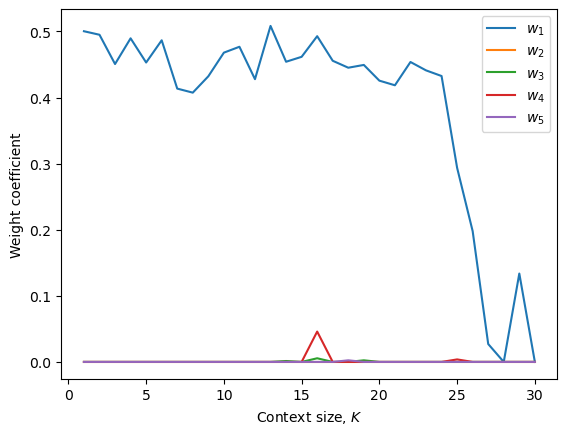

In [53]:
K_values = range(1, max_K + 1)
for i in range(5):
    plt.plot(K_values, weights[:,i])
plt.xlabel('Context size, $K$')
plt.ylabel('Weight coefficient')
plt.legend(['$w_'+str(i+1)+'$' for i in range(5)])
plt.show()

Observe that almost all coefficients $w_k$ for seasons $k$ years before the current season are effectively zero (plus noise), except for the immediately previous ($k=1$) season.
Also observe that $w_1(K)$ appears reasonable until about $K\approx 25$.

This single experiment suggests that only the ($K=1$) previous season offers any useful information to predict the current season. However, a single experiment may be spuriously  affected by
possibly unrepresentative sampling.
In order to try to overcome this problem, we now repeat the experiment multiple times and average over the results.

In [54]:
def run_multiple_experiments(team_data, num_experims, max_K, val_frac):
    all_est_scores =[]
    all_val_scores = []
    all_num_data = []

    for i in range(num_experims):
        print("Running experiment", i + 1, "...")
        _, est_scores, val_scores, num_data = run_one_experiment(team_data, val_frac, max_K)
        all_est_scores.append(est_scores)
        all_val_scores.append(val_scores)
        all_num_data.append(num_data)

    all_est_scores = np.mean(all_est_scores, axis=0)
    all_val_scores = np.mean(all_val_scores, axis=0)
    all_num_data = np.mean(all_num_data, axis=0)
    
    return all_est_scores, all_val_scores, all_num_data

In [55]:
num_experims = 20
max_K = 25

est_scores, val_scores, num_data = run_multiple_experiments(team_data, num_experims, max_K, val_frac)

Running experiment 1 ...
Running experiment 2 ...
Running experiment 3 ...
Running experiment 4 ...
Running experiment 5 ...
Running experiment 6 ...
Running experiment 7 ...
Running experiment 8 ...
Running experiment 9 ...
Running experiment 10 ...
Running experiment 11 ...
Running experiment 12 ...
Running experiment 13 ...
Running experiment 14 ...
Running experiment 15 ...
Running experiment 16 ...
Running experiment 17 ...
Running experiment 18 ...
Running experiment 19 ...
Running experiment 20 ...


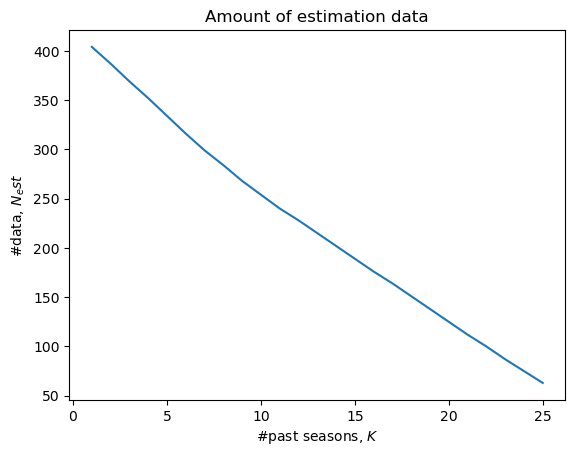

In [56]:
K_values = range(1, max_K + 1)
plt.plot(K_values, num_data)
plt.title("Amount of estimation data")
plt.xlabel("#past seasons, $K$")
plt.ylabel("#data, $N_est$")
plt.show()

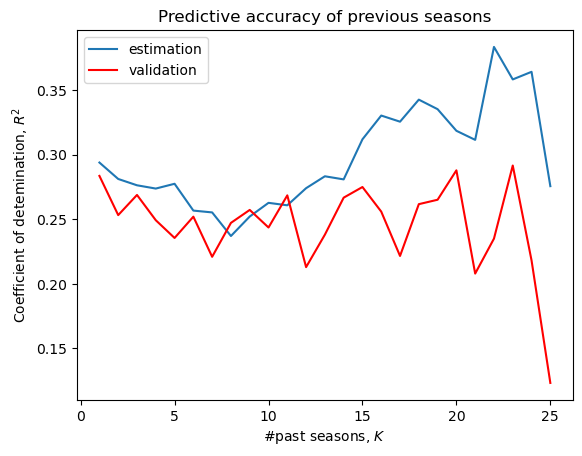

In [57]:
plt.plot(K_values, est_scores)
plt.plot(K_values, val_scores, 'r')
plt.title("Predictive accuracy of previous seasons")
plt.xlabel("#past seasons, $K$")
plt.ylabel("Coefficient of detemination, $R^2$")
plt.legend(['estimation', 'validation'])
plt.show()

We observe that the model behaves reasonably well for increasing $K$ until about $K\approx 15$, whereupon the validation score starts decreasing, indicating over-fittng (due to limited data). 
Note that for $K>25$ (not shown), the validation score actually becomes negative, as the 
model becomes worse than chance in explaining the residual variation.

We conclude that there appears to be little merit in using more than $K=1$ past seasons for a weighted, additive model. Other experiments (not shown here) also rule out using a weighted, multiplicative model. This is not unexpected, since, as noted at the end of the
[previous](#Temporal-averaging "Section: Temporal averaging") section,
a multiplicative weighting of probability estimates may be
transformed into an additively weighted model using the *logit* function. In other words, the predicted probability may also be represented via a *logistic* model of transformed probability estimates. However, this nonlinear transformation is clearly insufficient to extract further information from the seasonal time-series.

We have not yet ruled out other forms of multi-seasonal modelling, such as macro-averaging of statistics or analytics on multi-season match graphs. However, once again, other experiments (not shown here) suggest that the inclusion of further past seasons tends to add more noise to the
existing variation in the current season, and this extra variation degrades model performance.

Despite this, there might still be useful information hidden in the historical data. For example, if team A has never defated team B on team B's home ground, then this might be a strong indicator that team A's probability of winning is low, and we might be able to quantify this effect. However, rather than being a seasonal effect, this is more an issue for match prediction, which is the topic of the next chapter.